## Library Imports

In [ ]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from openai import OpenAI 
from src.utils.api_utils import play_wikispeedia_game
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

## Graph Analysis

In [2]:
# load data
df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])
print(df)

# Create directed graph
G = nx.from_pandas_edgelist(df, source='origin', target='destination', create_using=nx.DiGraph())

                                  origin     destination
0       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland
...                                  ...             ...
119877                              Zulu    South_Africa
119878                              Zulu       Swaziland
119879                              Zulu  United_Kingdom
119880                              Zulu          Zambia
119881                              Zulu        Zimbabwe

[119882 rows x 2 columns]


### Graph Statistics Analysis

In [3]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f'Number of nodes: {num_nodes}, Number of edges: {num_edges}, Density: {density}')

Number of nodes: 4592, Number of edges: 119882, Density: 0.005686496910710776


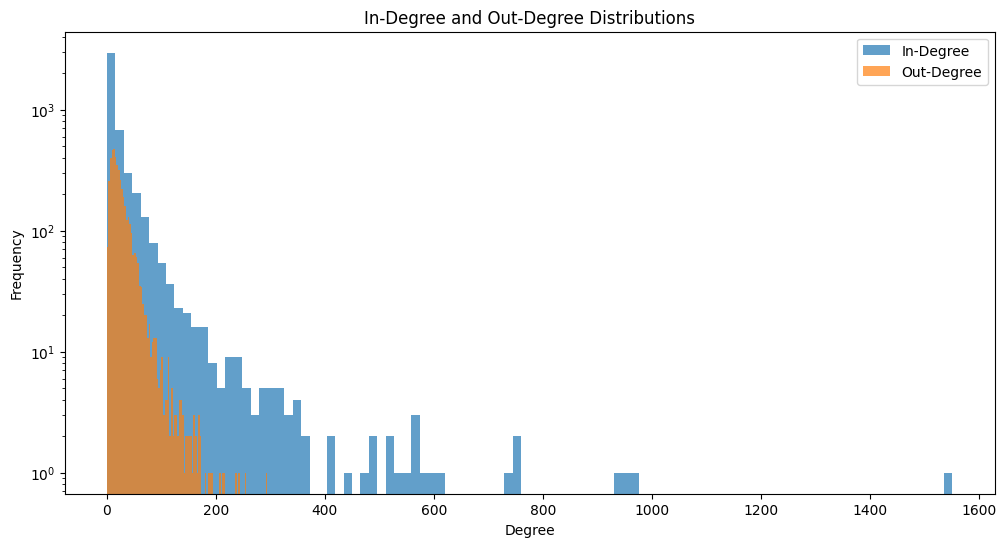

In [4]:
# Degree distributions
in_degrees = dict(G.in_degree())  
out_degrees = dict(G.out_degree()) 

plt.figure(figsize=(12, 6))
plt.hist(in_degrees.values(), bins=100, alpha=0.7, label='In-Degree')
plt.hist(out_degrees.values(), bins=100, alpha=0.7, label='Out-Degree')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("In-Degree and Out-Degree Distributions")
plt.show()

In [5]:
# Is the graph connected? 

num_weakly_connected_components = nx.number_weakly_connected_components(G)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

print(f"Number of weakly connected components: {num_weakly_connected_components}, Largest weakly connected component size: {len(largest_weakly_connected_component)}")

Number of weakly connected components: 2, Largest weakly connected component size: 4589


#### So there are only 3 nodes out of this component

In [7]:
# Path analysis in the largest component

largest_cc = G.subgraph(largest_weakly_connected_component).copy()

avg_shortest_path_length = nx.average_shortest_path_length(largest_cc.to_undirected())
diameter = nx.diameter(largest_cc.to_undirected())

print(f"Average shortest path length: {avg_shortest_path_length}, Diameter: {diameter}")

KeyboardInterrupt: 

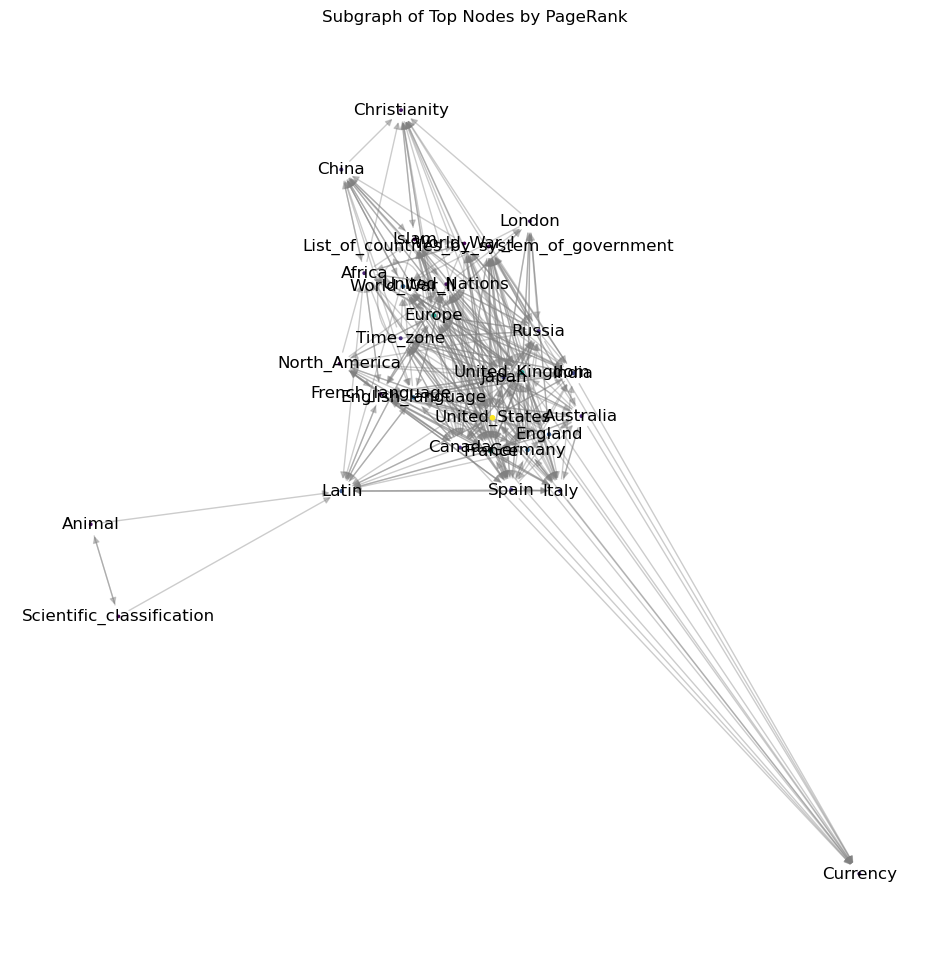

In [ ]:
# Get the important nodes
pagerank = nx.pagerank(G)

# Select the top 30 nodes using PageRank score and create a subgraph
top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:30]
G_top_pagerank = G.subgraph(top_nodes).copy()

# Plot the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_top_pagerank) 
node_sizes = [pagerank[node] * 1000 for node in G_top_pagerank]
node_colors = [pagerank[node] for node in G_top_pagerank]

# Plot nodes
nx.draw_networkx_nodes(
    G_top_pagerank,
    pos=pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis
)

# Plot edges 
nx.draw_networkx_edges(
    G_top_pagerank,
    pos=pos,
    edge_color="gray",
    alpha=0.4  # Make edges semi-transparent
)

# Plot labels
nx.draw_networkx_labels(
    G_top_pagerank,
    pos=pos,
    font_size=12,
    font_color="black"  # Set font color to black for better readability
)

plt.title("Subgraph of Top Nodes by PageRank")
plt.axis("off") 
plt.show()


## Human navigation paths analysis

In [8]:
paths_df = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep="\t", comment='#', header=None,
                       names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

In [9]:
# Calculate path length
paths_df["back_clicks"] = paths_df["path"].apply(lambda x: x.count('<'))
paths_df["raw_path_length"] = paths_df["path"].apply(lambda x: len(x.split(';')))  
paths_df["path_length"] = paths_df["raw_path_length"] - paths_df["back_clicks"] 

print("Average corrected path length:", paths_df["path_length"].mean())
print("Corrected path length distribution:\n", paths_df["path_length"].value_counts())

Average corrected path length: 6.356775400444288
Corrected path length distribution:
 path_length
5      11449
6       8877
4       8719
7       6147
8       4055
       ...  
103        1
72         1
60         1
49         1
48         1
Name: count, Length: 61, dtype: int64


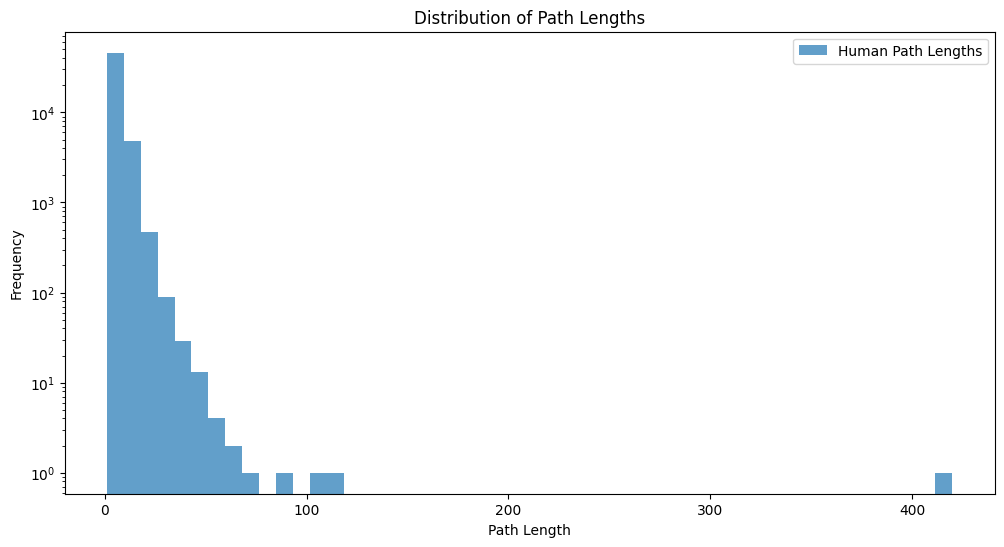

In [10]:
plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length"].dropna(), bins=50, alpha=0.7, label='Human Path Lengths')

# Add labels and title
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths")
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [11]:
# Get the optimal path length

shortest_path_matrix = dict(nx.all_pairs_shortest_path_length(G))

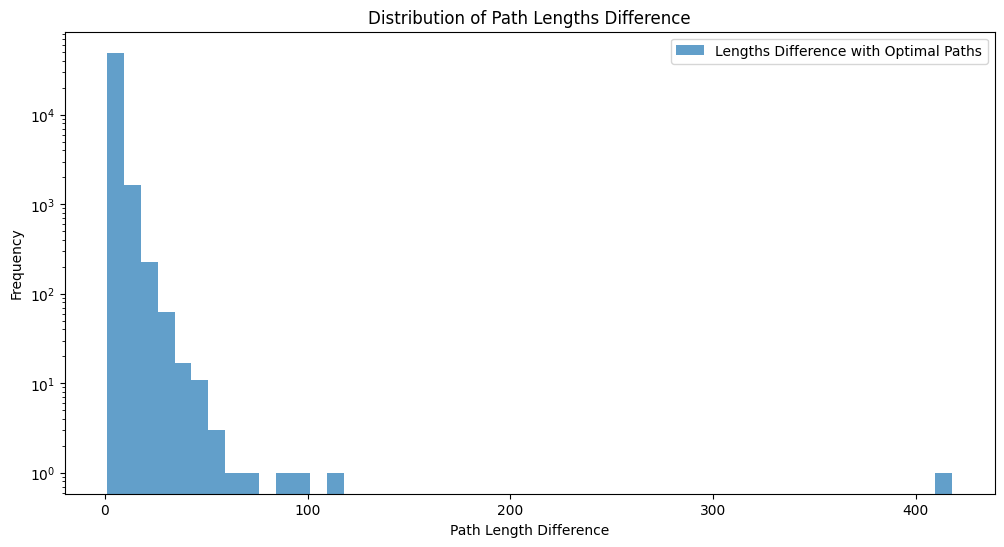

In [12]:
def calculate_shortest_path_length(path):
    articles = path.split(';')
    start_article = articles[0]
    end_article = articles[-1]
    if start_article != end_article:
        try:
            return shortest_path_matrix[start_article][end_article]
        except KeyError:
            return np.nan 
    return 0  

paths_df["shortest_path_length"] = paths_df["path"].apply(calculate_shortest_path_length)
paths_df["path_length_difference"] = paths_df["path_length"] - paths_df["shortest_path_length"]

plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length_difference"].dropna(), bins=50, alpha=0.7, label='Lengths Difference with Optimal Paths')

# Add labels and title
plt.xlabel("Path Length Difference")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths Difference")
plt.legend(loc='upper right')

# Show the plot
plt.show()

### Graph embedding and Sentence embedding to measure the distance between nodes, and the closeness score for each move 

In [ ]:
# Get graph embedding
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

graph_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities:   0%|          | 0/4592 [00:00<?, ?it/s]

In [ ]:
# Get Sentence embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = {node: model.encode(node.replace('_', ' ')) for node in G.nodes}

D:\Anaconda\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [ ]:
def plot_embeddings(embeddings): 
    embedding_values = list(embeddings.values())
    node_names = list(embeddings.keys())
    
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    embedding_2d = pca.fit_transform(embedding_values)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
    plot_df['node'] = node_names
    
    # Plot using seaborn for better aesthetics
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='x', y='y', data=plot_df, s=50, marker='o')
    
    # Optionally, annotate a few nodes for context
    for i, node in enumerate(plot_df['node']):
        if i % 100 == 0:  # Adjust this to annotate every nth node or specific nodes
            plt.text(plot_df['x'][i], plot_df['y'][i], node, fontsize=10)
    
    plt.title('2D Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

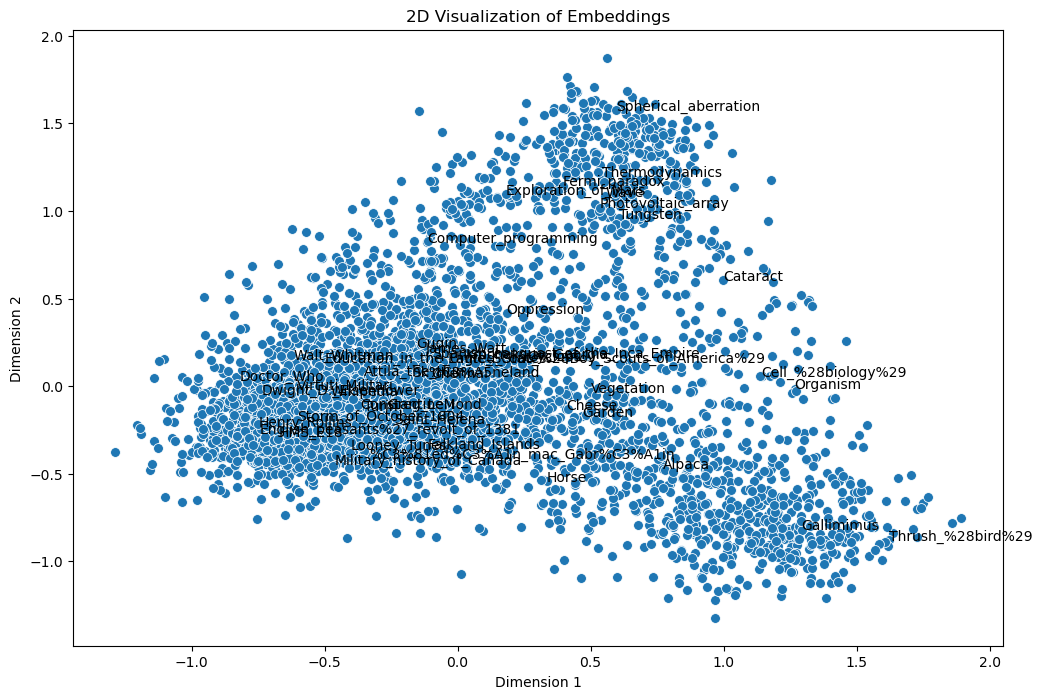

In [ ]:
plot_embeddings(graph_embeddings)

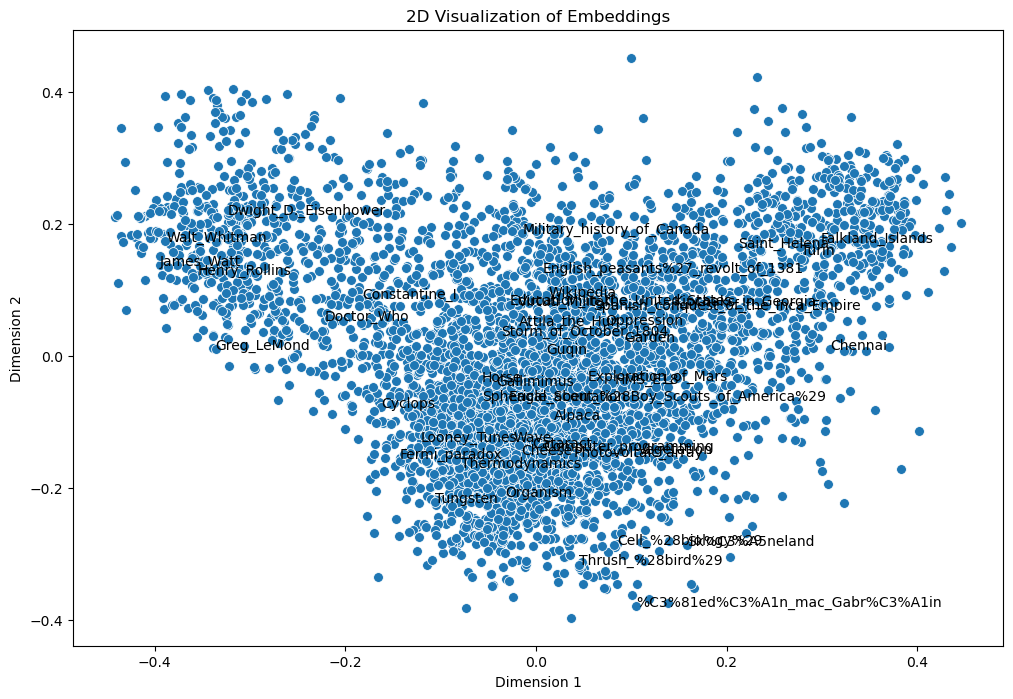

In [ ]:
plot_embeddings(sentence_embeddings)

In [ ]:
from scipy.spatial.distance import cosine

# Compute cosine distance between two embeddings
def embedding_distance(node1, node2, embeddings):
    if node1 not in embeddings or node2 not in embeddings:
        return np.nan  
    return cosine(embeddings[node1], embeddings[node2])

# Calculate the closeness scores for each human navigation path
def calculate_closeness_scores(path, embeddings):
    articles = path.split(';')
    destination = articles[-1]  
    closeness_scores = []

    # Compute the initial distance to the destination
    prev_distance = embedding_distance(articles[0], destination, embeddings)

    for i in range(1, len(articles)):
        current_node = articles[i]
        if current_node == '<':
            continue   # This case should be handled!

        # Calculate the distance from the current node to the destination
        current_distance = embedding_distance(current_node, destination, embeddings)
        
        # Calculate the closeness score: distance difference from previous move
        closeness_score = prev_distance - current_distance
        closeness_scores.append(closeness_score)

        # Update the previous distance for the next move
        prev_distance = current_distance

    return closeness_scores

# Calculate the closeness scores for the optimal path in graph G
def calculate_optimal_closeness_scores(path, embeddings, G):
    articles = path.split(';')
    destination = articles[-1]  
    closeness_scores_optimal = []
    
    # Calculate shortest path in the graph G
    try:
        shortest_path = nx.shortest_path(G, source=articles[0], target=destination)
    except:
        print(f"source: {articles[0]}, destination: {destination}")
        return []
    # Compute the initial distance to the destination
    prev_distance_optimal = embedding_distance(articles[0], destination, embeddings)

    for i in range(1, len(shortest_path)):
        current_node = shortest_path[i]

        current_distance_optimal = embedding_distance(current_node, destination, embeddings)
        closeness_score_optimal = prev_distance_optimal - current_distance_optimal
        closeness_scores_optimal.append(closeness_score_optimal)

        prev_distance_optimal = current_distance_optimal

    return closeness_scores_optimal

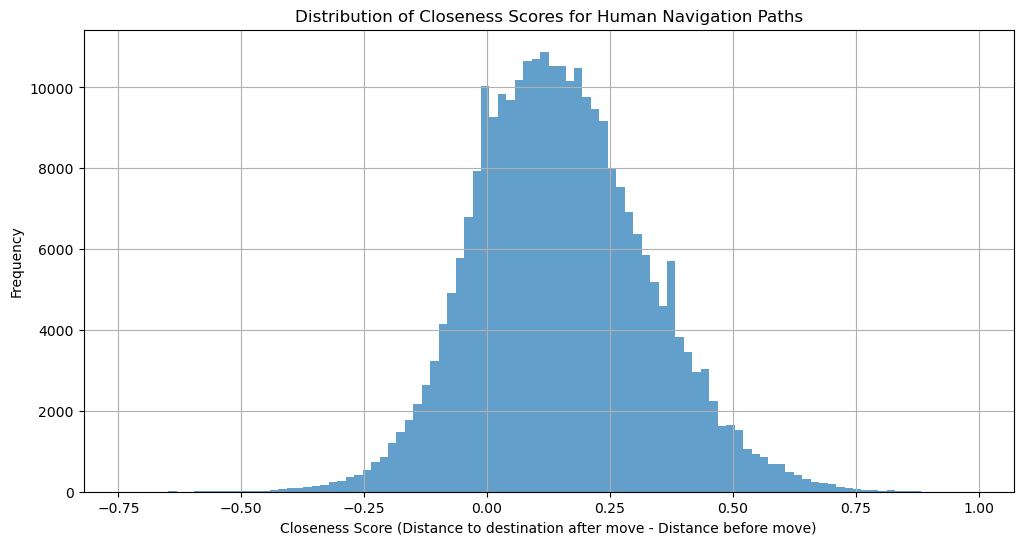

In [ ]:
# Calculate the closeness score based on graph embeddings
paths_df['closeness_scores'] = paths_df['path'].apply(lambda x: calculate_closeness_scores(x, graph_embeddings))

# Flatten the closeness scores for plotting
all_closeness_scores = [score for sublist in paths_df['closeness_scores'].dropna() for score in sublist]

# Plot the closeness scores
plt.figure(figsize=(12, 6))
plt.hist(all_closeness_scores, bins=100, alpha=0.7)
plt.xlabel('Closeness Score (Distance to destination after move - Distance before move)')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Scores for Human Navigation Paths')
plt.grid(True)
plt.show()

source: Bird, destination: Wikipedia_Text_of_the_GNU_Free_Documentation_License


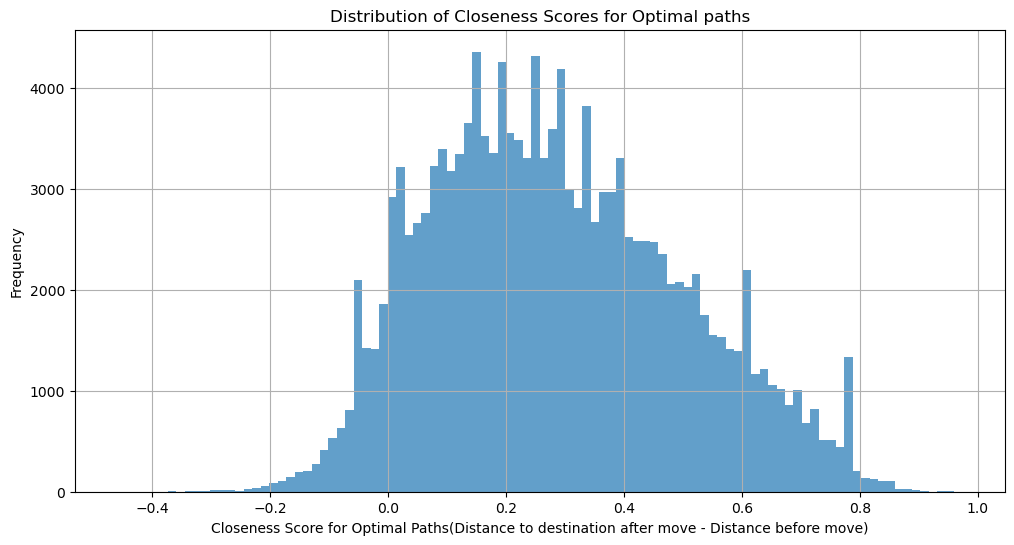

In [ ]:
# Calculate the closeness score for optimal paths based on graph embeddings
paths_df['optimal_closeness_scores'] = paths_df['path'].apply(lambda x: calculate_optimal_closeness_scores(x, graph_embeddings, G))

# Flatten the closeness scores for plotting
all_optimal_closeness_scores = [score for sublist in paths_df['optimal_closeness_scores'].dropna() for score in sublist]

# Plot the closeness scores
plt.figure(figsize=(12, 6))
plt.hist(all_optimal_closeness_scores, bins=100, alpha=0.7)
plt.xlabel('Closeness Score for Optimal Paths(Distance to destination after move - Distance before move)')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Scores for Optimal paths')
plt.grid(True)
plt.show()

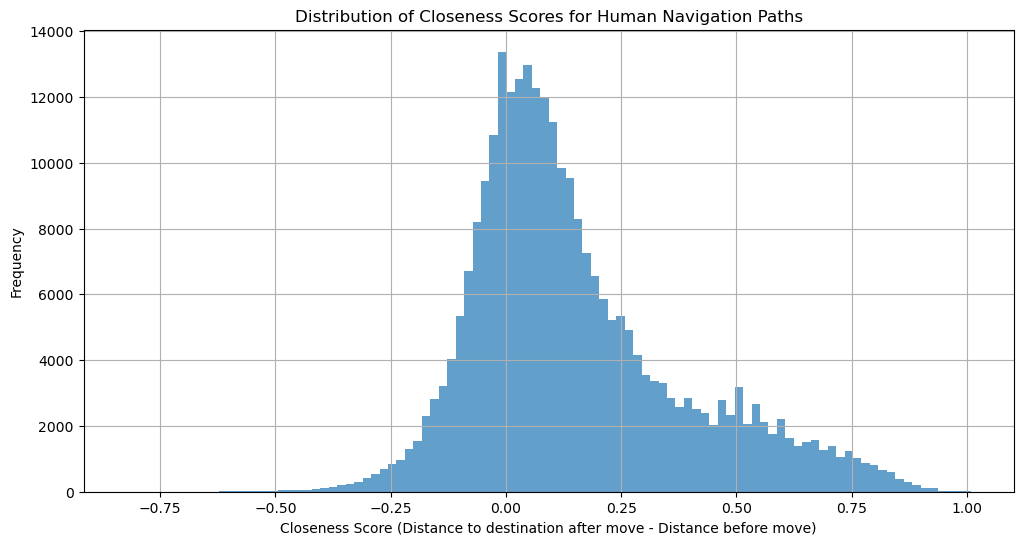

In [ ]:
# Calculate the closeness score based on sentence embeddings
paths_df['closeness_scores'] = paths_df['path'].apply(lambda x: calculate_closeness_scores(x, sentence_embeddings))

# Flatten the closeness scores for plotting
all_closeness_scores = [score for sublist in paths_df['closeness_scores'].dropna() for score in sublist]

# Plot the closeness scores
plt.figure(figsize=(12, 6))
plt.hist(all_closeness_scores, bins=100, alpha=0.7)
plt.xlabel('Closeness Score (Distance to destination after move - Distance before move)')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Scores for Human Navigation Paths')
plt.grid(True)
plt.show()

source: Bird, destination: Wikipedia_Text_of_the_GNU_Free_Documentation_License


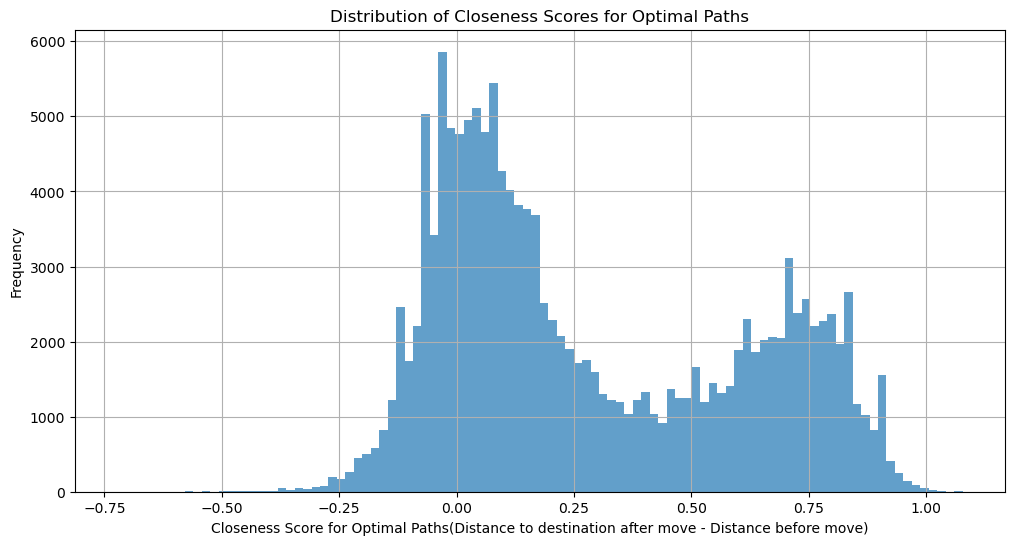

In [ ]:
# Calculate the closeness score for optimal paths based on sentence embeddings
paths_df['optimal_closeness_scores'] = paths_df['path'].apply(lambda x: calculate_optimal_closeness_scores(x, sentence_embeddings, G))

# Flatten the closeness scores for plotting
all_optimal_closeness_scores = [score for sublist in paths_df['optimal_closeness_scores'].dropna() for score in sublist]

# Plot the closeness scores
plt.figure(figsize=(12, 6))
plt.hist(all_optimal_closeness_scores, bins=100, alpha=0.7)
plt.xlabel('Closeness Score for Optimal Paths(Distance to destination after move - Distance before move)')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Scores for Optimal Paths')
plt.grid(True)
plt.show()

In [ ]:
# an example for closeness score
path = "14th_century;Time;Isaac_Newton;Light;Color;Rainbow"
print(f"path: {path}")
print(f"Clossness score based on graph embeddings:\n {calculate_closeness_scores(path, graph_embeddings)}")
print(f"Clossness score based on sentence embeddings:\n {calculate_closeness_scores(path, sentence_embeddings)}")
print(f"optimal path: {nx.shortest_path(G, source='14th_century', target='Rainbow')}")
print(f"Clossness score based on graph embeddings:\n {calculate_optimal_closeness_scores(path, graph_embeddings, G)}")
print(f"Clossness score based on sentence embeddings:\n {calculate_optimal_closeness_scores(path, sentence_embeddings, G)}")

path: 14th_century;Time;Isaac_Newton;Light;Color;Rainbow
Clossness score based on graph embeddings:
 [0.20651862632317886, 0.23847089551219447, 0.016758027750125915, 0.10423748790890008, 0.22081366958686577]
Clossness score based on sentence embeddings:
 [0.16504409999509884, -0.07526734084629827, 0.2794282006876594, 0.07566121671564685, 0.4398911857540112]
optimal path: ['14th_century', 'Time', 'Isaac_Newton', 'Rainbow']
Clossness score based on graph embeddings:
 [0.20651862632317886, 0.23847089551219447, 0.34180918524589177]
Clossness score based on sentence embeddings:
 [0.16504409999509884, -0.07526734084629827, 0.7949806031573174]


#### We can see in this case, the human navigation path tends to gradually approach the destination, so the semantic closeness scores are relatively smooth, whereas the optimal path directly get to the destination, which causes larger closeness scores. That could be a reason for the bimodal distribution of Closeness score for optimal paths based on sentence embedding

## Article analysis

### Title analysis

In this part, we explored various features across all articles. We collected data on title length, high-frequency words, and titles containing years, hypothesizing that these factors might influence path selection in the game.

In [ ]:
import pandas as pd
from urllib.parse import unquote

articles = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', 
                      sep='\t', 
                      comment='#', 
                      header=None,
                      names=['article'])
# unquote the titles
articles = articles.map(unquote)
articles.head()

article
0      Áedán_mac_Gabráin
1                  Åland
2          Édouard_Manet
3                   Éire
4  Óengus_I_of_the_Picts

In [ ]:
# print the shape
print(f'articles.shape: {articles.shape}')

articles.shape: (4604, 1)


In [ ]:
# print the frequency of each word occurred in the titles
articles['article'].str.split('_').explode().value_counts()

article
of          431
the         126
The          73
and          64
United       48
           ... 
Lloyd         1
Francium      1
Goya          1
Assisi        1
Zulu          1
Name: count, Length: 5585, dtype: int64

Among the high-frequency words, meaningful terms such as "United," "History," "England," and "War" appeared frequently. This may indicate a selection bias in the data or reflect topics that attract more attention. 

In [ ]:
# the length of titles may affect human's preference
articles['article'].str.len().describe()

count    4604.000000
mean       13.637489
std         7.777092
min         2.000000
25%         8.000000
50%        12.000000
75%        17.000000
max        83.000000
Name: article, dtype: float64

In [ ]:
# the titles with specified year may affect human's preference
contain_year = articles[articles['article'].str.contains(r'\b\d{4}\b')]
print(f'Counts: {len(contain_year)}\n{contain_year}')

Counts: 40
                                  article
511             Battle_of_Smolensk_(1943)
515               Battle_of_Warsaw_(1920)
520            Battle_of_the_Somme_(1916)
1368          Elizabethan_Poor_Law_(1601)
1961        History_of_Poland_(1945–1989)
1962      History_of_Portugal_(1777–1834)
2040                Hurricane_Alex_(2004)
2044               Hurricane_Danny_(1997)
2047             Hurricane_Edouard_(1996)
2048             Hurricane_Epsilon_(2005)
2049               Hurricane_Felix_(1995)
2054                Hurricane_John_(1994)
2055                Hurricane_John_(2006)
2058               Hurricane_Marty_(2003)
2060            Hurricane_Philippe_(2005)
2061               Hurricane_Vince_(2005)
2427         Laws_in_Wales_Acts_1535–1542
3290     Polish–Muscovite_War_(1605–1618)
3292     Polish-Muscovite_War_(1605–1618)
3745  Sino-German_cooperation_(1911-1941)
4223            Tropical_Storm_Ana_(2003)
4224          Tropical_Storm_Bilis_(2006)
4225         Tropical_S

Only 40 titles contain years, representing a very small proportion of the dataset.

### Categories analysis
We analyzed the characteristics of the categories as well as their distribution. 

In [ ]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote 
categories = categories.map(unquote)
categories.head()

article                                           category
0  Áedán_mac_Gabráin  subject.History.British_History.British_Histor...
1  Áedán_mac_Gabráin                  subject.People.Historical_figures
2              Åland                                  subject.Countries
3              Åland  subject.Geography.European_Geography.European_...
4      Édouard_Manet                             subject.People.Artists

In [ ]:

nodes = {}
# Process each row to build the nodes
for _, row in categories.iterrows():
    category_parts = row['category'].split('.')
    article = row['article']
    path_parts = category_parts + [article]

    for i, part in enumerate(path_parts):
        node_id = '.'.join(category_parts[:i] + [part])
        parent_id = '.'.join(category_parts[:i]) if i > 0 else ''
        if node_id not in nodes:
            nodes[node_id] = {
                'id': node_id,
                'name': part,
                'parent': parent_id,
                'size': 0
            }
        nodes[node_id]['size'] += 1

nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
# Calculate relative sizes
parent_sizes = nodes_df.set_index('id')['size'].to_dict()
nodes_df['relative_size'] = nodes_df.apply(
    lambda row: (row['size'] / parent_sizes.get(row['parent'], row['size'])) * 100
    if parent_sizes.get(row['parent'], row['size']) else 100,
    axis=1
)

In [ ]:
import random
import plotly.graph_objects as go

def create_treemap(ids, labels, parents, values, hover_text):

    # generate random deep colors
    colors = [f"#{random.randint(30, 150):02x}{random.randint(30, 150):02x}{random.randint(30, 150):02x}" for _ in ids]

    fig = go.Figure(go.Treemap(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        hovertext=hover_text,
        hoverinfo="text",
        maxdepth=2,
        branchvalues="total",
        marker=dict(colors=colors, line=dict(width=1, color='#000000')),
        textfont=dict(color='white', size=16), 
        textposition="middle center", 
        hoverlabel=dict(bgcolor='#2c3e50', font=dict(color='white'))
    ))

    fig.update_layout(
        width=1000,
        height=800,
        title=dict(
            text="Category-Article Treemap",
            xanchor='center',
            x=0.5,
            yanchor='top',
            font=dict(color='white')
        ),
        paper_bgcolor='#111111',
        plot_bgcolor='#111111',
        font=dict(color='white')
    )

    return fig

In [ ]:
ids, parents, values = nodes_df['id'], nodes_df['parent'], nodes_df['size']

# Fill NaN values in relative_size with 0 before rounding
nodes_df['relative_size'] = nodes_df['relative_size'].fillna(0)

labels = nodes_df.apply(
    lambda row: f"{row['name']}" if row['size'] == 1 else f"{row['name']}<br>({row['relative_size']:.2f}%)",
    axis=1
)

hover_text =  nodes_df.apply(
    lambda row: "Article" if row['size'] == 1 else
    f"Full Category: {row['id']}<br>"
    f"Size: {row['size']}<br>"
    f"Percentage: {row['relative_size']:.2f}%",
    axis=1
)
fig = create_treemap(ids, labels, parents, values, hover_text)
fig.show()
fig.write_html("./charts/category-article_treemap.html")


Github preview is not working for this plotly chart. 

Please check here: https://epfl-ada.github.io/ada-2024-project-genshinstart/charts/category-article_treemap.html

In [ ]:
# print the shape
print(f'categories.shape: {categories.shape}')

categories.shape: (5204, 2)


In [ ]:
# Use a list to store the categories for each article 
# and calculate the number of categories
articles_categories = pd.DataFrame(articles, columns=['article'])

category_dict = categories.groupby('article')['category'].apply(list).to_dict()
articles_categories['categories'] = articles_categories['article'].map(category_dict).apply(lambda x: x if isinstance(x, list) else [])
articles_categories['num_categories'] = articles_categories['categories'].apply(len)

len(articles_categories)

4604

In [ ]:
# Count the occurrence frequency of each num_categories value
num_categories_counts = articles_categories['num_categories'].value_counts().sort_index().to_frame(name='count')
total = num_categories_counts['count'].sum()
num_categories_counts['percentage'] = (num_categories_counts['count'] / total) * 100
num_categories_counts

count  percentage
num_categories                   
0                   6    0.130321
1                4000   86.880973
2                 590   12.814944
3                   8    0.173762

Over 85% of articles are assigned to only one category, with a small portion belonging to two, and other counts being close to zero.

### links analysis
Most of the analysis on links (such as PageRank) has already been covered in the previous section, 'Graph Analysis.' Here, additional data details are presented as a supplement.

In [ ]:
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv',
                     sep='\t',
                     comment='#',
                     header=None,
                     names=['from', 'to'])
# unquote
links = links.map(unquote)
links.head()

from             to
0  Áedán_mac_Gabráin           Bede
1  Áedán_mac_Gabráin        Columba
2  Áedán_mac_Gabráin      Dál_Riata
3  Áedán_mac_Gabráin  Great_Britain
4  Áedán_mac_Gabráin        Ireland

In [ ]:
def find_most_detailed_common_category(article1, article2):
    # Get all categories for both articles
    categories1 = categories[categories['article'] == article1]['category'].tolist()
    categories2 = categories[categories['article'] == article2]['category'].tolist()
    
    # Early return if either article has no categories
    if not categories1 or not categories2:
        return None
    
    # Convert categories to sets of all prefixes for efficient lookup
    def get_all_prefixes(category):
        parts = category.split('.')
        return {'.'.join(parts[:i+1]) for i in range(len(parts))}
    
    # Get all possible prefixes for each category
    prefixes1 = {prefix for cat in categories1 for prefix in get_all_prefixes(cat)}
    prefixes2 = {prefix for cat in categories2 for prefix in get_all_prefixes(cat)}
    
    # Find common prefixes
    common_categories = prefixes1.intersection(prefixes2)
    
    if not common_categories:
        return None
        
    # Return the longest common category
    return max(common_categories, key=len)

In [ ]:
def analyze_category_depths(links_df):
    def count_depth(category):
        if category is None:
            return 0
        return len(category.split('.'))
    
    depths = []
    
    # Analyze each link
    for _, row in links_df.iterrows():
        from_article = row['from']
        to_article = row['to']
        
        # Find the most detailed common category
        common_category = find_most_detailed_common_category( from_article, to_article)
        # Count the depth
        depth = count_depth(common_category)
        depths.append(depth)
    
    # Calculate distribution
    distribution = {}
    for depth in depths:
        distribution[depth] = distribution.get(depth, 0) + 1
        
    return distribution

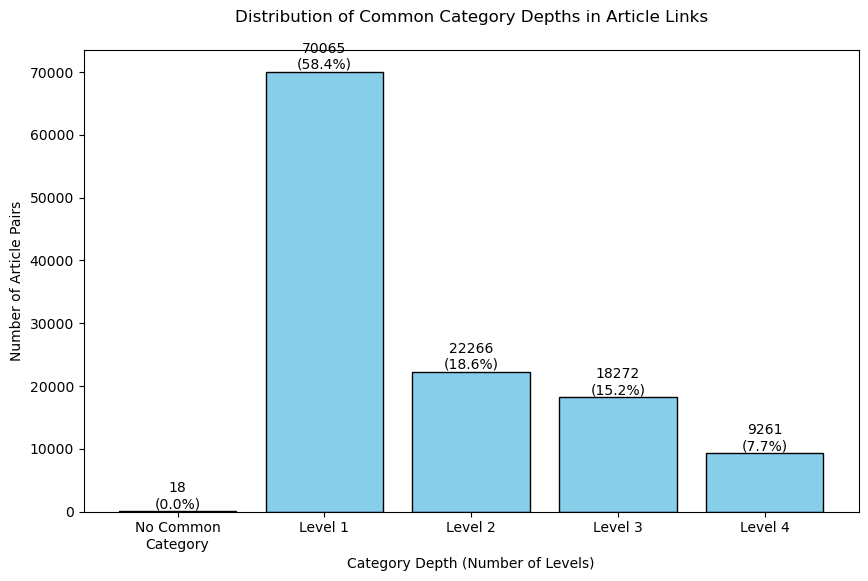

In [ ]:
distribution = analyze_category_depths(links)

def plot_category_depth_distribution(distribution):

    plt.figure(figsize=(10, 6))

    # Create bar plot
    depths = list(distribution.keys())
    counts = list(distribution.values())

    plt.bar(depths, counts, color='skyblue', edgecolor='black')

    # Calculate ratios
    total_counts = sum(counts)
    percentages = [(count / total_counts) * 100 for count in counts]

    # Customize plot
    plt.title('Distribution of Common Category Depths in Article Links', pad=20)
    plt.xlabel('Category Depth (Number of Levels)')
    plt.ylabel('Number of Article Pairs')

    # Add value labels on top of each bar
    for i, (count, percent) in enumerate(zip(counts, percentages)):
        plt.text(depths[i], count, f'{count}\n({percent:.1f}%)', 
                ha='center', va='bottom')

    # Set x-axis ticks
    plt.xticks(depths, [f'Level {d}' if d > 0 else 'No Common\nCategory' for d in depths])


    plt.show()
    
plot_category_depth_distribution(distribution)

- We could tell that over half of the links don't share a common category since the level 1 category is 'subject' which is the highest level of category.

In [ ]:
# The number of edges
len(links)

119882

In [ ]:
out_degree = links['from'].value_counts().reset_index()
out_degree.columns = ['article', 'out_degree']
out_degree.head()

article  out_degree
0                   United_States         294
1    Driving_on_the_left_or_right         255
2               List_of_countries         244
3  List_of_circulating_currencies         236
4        List_of_sovereign_states         216

In [ ]:
in_degree = links['to'].value_counts().reset_index()
in_degree.columns = ['article', 'in_degree']
in_degree.head()

article  in_degree
0   United_States       1551
1  United_Kingdom        972
2          France        959
3          Europe        933
4         England        751

### Path analysis

This section serves as a supplement to the Human Navigation Paths Analysis. We experimented with multiple methods of calculating path lengths: excluding backtrack symbols from the path length (mentioned before); excluding both backtracked pages and backtrack symbols; and using the full path length, including backtrack symbols. This human-specific behavior may suggest some distinctions compared to the LLM. We also observed that as the difficulty rating increases, path length tends to rise.

In the analysis of unfinished paths, we also explored the path length. Based on the data, it appears that giving up on a path is not necessarily due to excessive path length, as the average length is comparable to paths with difficulty ratings of 1.0 to 2.0. Most users abandon paths due to restarts rather than timeouts.

In [ ]:
def load_and_unquote_paths(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=column_names)
    df['path'] = df['path'].map(unquote)
    return df

paths_finished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_finished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','rating'])
paths_finished.head()

hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   
2  415612e93584d30e  1349298640            138   
3  64dd5cd342e3780c  1265613925             37   
4  015245d773376aab  1366730828            175   

                                                path  rating  
0  14th_century;15th_century;16th_century;Pacific...     NaN  
1  14th_century;Europe;Africa;Atlantic_slave_trad...     3.0  
2  14th_century;Niger;Nigeria;British_Empire;Slav...     NaN  
3     14th_century;Renaissance;Ancient_Greece;Greece     NaN  
4  14th_century;Italy;Roman_Catholic_Church;HIV;R...     3.0

In [ ]:
# clean paths by removing back navigation ('<') and corresponding nodes.

cleaned_paths = []

for path in paths_finished['path']:
    nodes = path.split(';')
    stack = []
    
    for node in nodes:
        if node == '<':
            if stack:  
                stack.pop()
        else:
            stack.append(node)
    
    cleaned_path = ';'.join(stack)
    cleaned_paths.append(cleaned_path)

paths_finished['path'] = cleaned_paths

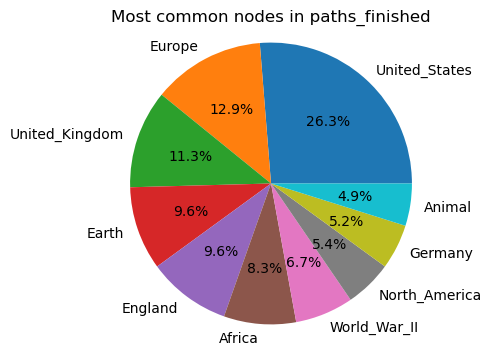

In [ ]:
from collections import Counter

all_paths = ';'.join(paths_finished['path'])
nodes = all_paths.split(';')
node_counts = Counter(nodes)

import matplotlib.pyplot as plt

# pie chart of the most common nodes
top_nodes = node_counts.most_common(10)
# split the nodes and counts
nodes, counts = zip(*top_nodes)
plt.figure(figsize=(4,4))
plt.title('Most common nodes in paths_finished')
plt.pie(counts, labels=nodes, autopct='%1.1f%%')
plt.axis('equal')
plt.show()


In [ ]:
# find the easiest path
paths_finished['path'].value_counts().head(10)

path
Brain;Computer_science;Information;Communication;Telephone             160
Bird;Fish;Whale_shark;Shark;Great_white_shark                           90
Asteroid;Earth;Europe;Norway;Viking                                     83
Theatre;India;Mammal;Zebra                                              79
Theatre;Dance;Animal;Mammal;Zebra                                       74
Brain;Computer_science;Internet;World_Wide_Web;Telephone                44
Brain;Computer_science;Internet;Information;Communication;Telephone     44
Batman;Scotland;Agriculture;Fossil_fuel;Wood                            38
Brain;Animal;Human;Communication;Telephone                              30
Pyramid;Ancient_Egypt;Cereal;Seed;Bean                                  30
Name: count, dtype: int64

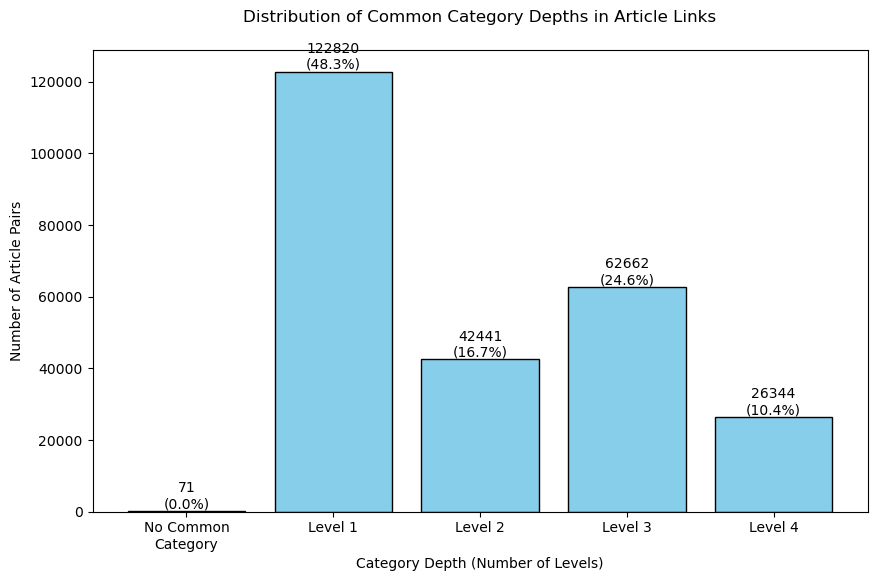

In [ ]:
df = pd.DataFrame(columns=['from', 'to'])
rows = []
for path in paths_finished['path']:
    nodes = path.split(';')
    for i in range(len(nodes) - 1):
        rows.append({'from': nodes[i], 'to': nodes[i + 1]})

df = pd.DataFrame(rows)

plot_category_depth_distribution(analyze_category_depths(df))

In the path analysis, we could see that the level of common category between the source and target is rising, which maybe can indicate that if the source and target have more common categories, the path is easier for humans to find.


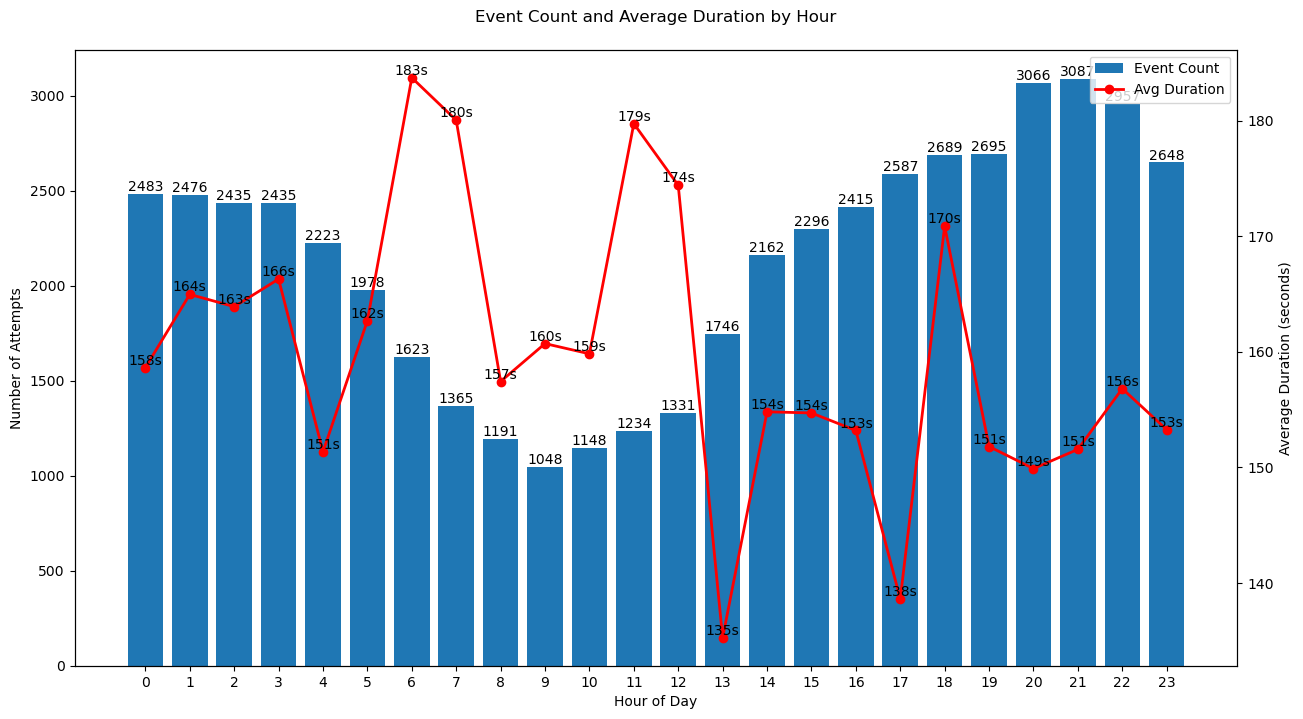

In [ ]:
# analyze the time of day when the most attempts are made and the average duration of the attempts
def analyze_time_info(paths_finished):
    paths_finished['datetime'] = pd.to_datetime(paths_finished['timestamp'], unit='s')
    paths_finished['hour'] = paths_finished['datetime'].dt.hour

    hourly_stats = paths_finished.groupby('hour').agg({
        'timestamp': 'count',  
        'durationInSec': 'mean'  
    }).reset_index()

    fig, ax1 = plt.subplots(figsize=(15, 8))
    bars = ax1.bar(hourly_stats['hour'], hourly_stats['timestamp'], label='Event Count')
    ax2 = ax1.twinx()
    line = ax2.plot(hourly_stats['hour'], hourly_stats['durationInSec'], 
                    color='red', linewidth=2, marker='o', label='Avg Duration')

    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Attempts')

    ax2.set_ylabel('Average Duration (seconds)')

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')

    for x, y in zip(hourly_stats['hour'], hourly_stats['durationInSec']):
        ax2.text(x, y, f'{int(y)}s', 
                 ha='center', va='bottom')

    plt.title('Event Count and Average Duration by Hour', pad=20)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.xticks(hourly_stats['hour'], rotation=45)

    plt.show()

analyze_time_info(paths_finished)

Maybe there's some bias in the data, but we can tell from the figure people are less likely to play the game in morning and have a hard time in making decisions.

Seems like the morning time is not the best time for gamers, even in this one.

In [ ]:
# 1. calculate the depth of each path based on the common category of the start and end nodes

paths_finished['start_end_depth'] = None  
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')))  

for idx, path in enumerate(paths_finished['path']):
    try:
        articles = path.split(';')
        start_end_category = find_most_detailed_common_category(articles[0], articles[-1])
        depth = len(start_end_category.split('.')) if start_end_category else 0
        paths_finished.loc[paths_finished.index[idx], 'start_end_depth'] = depth
    except Exception as e:
        print(f"Error processing path at index {idx}: {e}")
        continue

# 2. analyze each path node
depth_stats = {}
for depth in sorted(paths_finished['start_end_depth'].unique()):
    # get paths with the current depth
    depth_paths = paths_finished[paths_finished['start_end_depth'] == depth]
    
    # calculate the average depth of each path
    path_avg_depths = []
    for path in depth_paths['path']:
        articles = path.split(';')
        step_depths = []
        
        # calculate the depth between each pair of articles
        for i in range(len(articles) - 1):
            common_category = find_most_detailed_common_category(articles[i], articles[i+1])
            step_depth = len(common_category.split('.')) if common_category else 0
            step_depths.append(step_depth)
        
            path_avg_depths.append(sum(step_depths) / len(step_depths))
    
    depth_stats[depth] = {
        'path_count': len(depth_paths),
        'avg_step_depth': sum(path_avg_depths) / len(path_avg_depths),
        'avg_path_length': depth_paths['path_length'].mean(),
        'avg_duration': depth_paths['durationInSec'].mean(),
        'avg_rating': depth_paths['rating'].mean(),
        'zero_depth_ratio': sum(1 for d in path_avg_depths if d == 0) / len(path_avg_depths)
    }


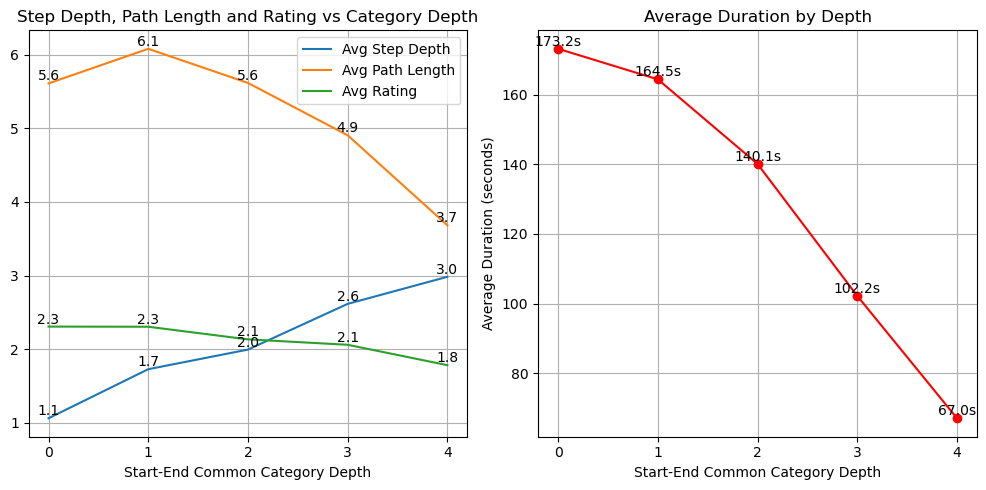

In [ ]:
fig = plt.figure(figsize=(10, 5))
depths = list(depth_stats.keys())

# 1. Average Metrics Trends
ax1 = plt.subplot(1, 2, 1)
metrics = {
    'Avg Step Depth': [depth_stats[d]['avg_step_depth'] for d in depths],
    'Avg Path Length': [depth_stats[d]['avg_path_length'] for d in depths],
    'Avg Rating': [depth_stats[d]['avg_rating'] for d in depths]
}
for label, values in metrics.items():
    ax1.plot(depths, values, label=label)
    for i, value in enumerate(values):
        ax1.text(depths[i], value, f'{value:.1f}', ha='center', va='bottom')
ax1.set_title('Step Depth, Path Length and Rating vs Category Depth')
ax1.set_xlabel('Start-End Common Category Depth')
ax1.set_xticks(depths)  # Set specific x-ticks
ax1.legend()
ax1.grid(True)

# 2. Completion Time Distribution
ax2 = plt.subplot(1, 2, 2)
durations = [depth_stats[d]['avg_duration'] for d in depths]
ax2.plot(depths, durations, marker='o', color='red')
ax2.set_title('Average Duration by Depth')
ax2.set_xlabel('Start-End Common Category Depth')
ax2.set_ylabel('Average Duration (seconds)')
ax2.set_xticks(depths)  # Set specific x-ticks
ax2.grid(True)
# Add value labels
for i, duration in enumerate(durations):
    ax2.text(depths[i], duration, f'{duration:.1f}s', ha='center', va='bottom')


plt.tight_layout()
plt.show()



In [ ]:
paths_finished.shape

(51318, 9)

In [ ]:
# calculate the whole length of each path
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len([p for p in x.split(';')]))
path_finished_analysis = paths_finished[['path_length', 'rating', 'durationInSec']].copy()
path_finished_analysis.head()

path_length  rating  durationInSec
0            9     NaN            166
1            5     3.0             88
2            8     NaN            138
3            4     NaN             37
4            7     3.0            175

In [ ]:
# observe the difference in path lengths at different ratings
path_finished_analysis_rated = path_finished_analysis.dropna()
stats = path_finished_analysis_rated.groupby('rating')['path_length'].agg(['mean', 'median', 'std']).reset_index()

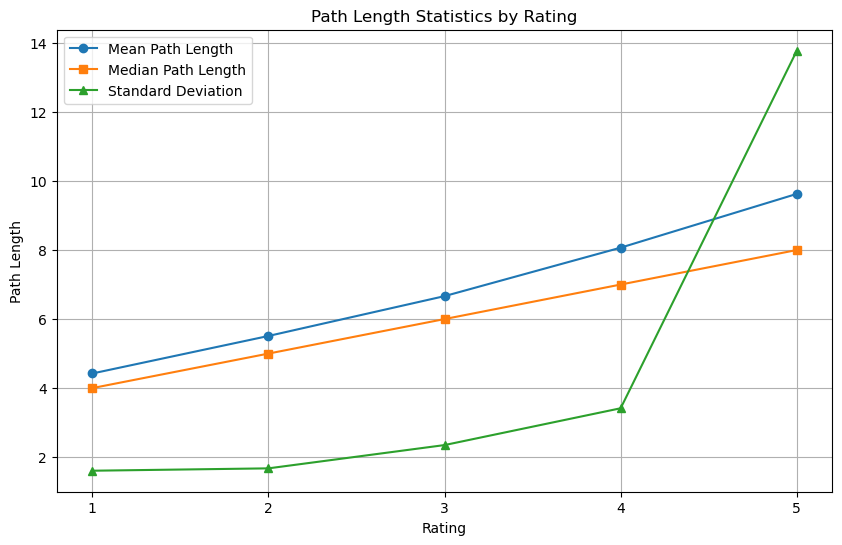

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(stats['rating'], stats['mean'], marker='o', label='Mean Path Length')
plt.plot(stats['rating'], stats['median'], marker='s', label='Median Path Length')
plt.plot(stats['rating'], stats['std'], marker='^', label='Standard Deviation')
plt.xticks(stats['rating'])
plt.xlabel('Rating')
plt.ylabel('Path Length')
plt.title('Path Length Statistics by Rating')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
paths_unfinished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','target','type'])
paths_unfinished.head()

hashedIpAddress   timestamp  durationInSec  \
0  2426091a53125110  1297054935           1804   
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
3  53a53bc244e08a6a  1297094761             49   
4  53a53bc244e08a6a  1297099105           1808   

                                   path            target     type  
0                        Obi-Wan_Kenobi         Microsoft  timeout  
1                         Julius_Caesar           Caracas  timeout  
2  Malawi;Democracy;Alexander_the_Great     First_Crusade  timeout  
3                              Paraguay  Mount_St._Helens  restart  
4                      Paraguay;Bolivia  Mount_St._Helens  timeout

In [ ]:
# remove path with only single node
paths_unfinished = paths_unfinished[paths_unfinished['path'].str.contains(';')]
# remove the back navigation
cleaned_paths = []

for path in paths_unfinished['path']:
    nodes = path.split(';')
    stack = []
    
    for node in nodes:
        if node == '<':
            if stack:  
                stack.pop()
        else:
            stack.append(node)
    
    cleaned_path = ';'.join(stack)
    cleaned_paths.append(cleaned_path)

paths_unfinished['path'] = cleaned_paths

paths_unfinished

hashedIpAddress   timestamp  durationInSec  \
2      2b015fb8181c48f2  1297090819           1818   
4      53a53bc244e08a6a  1297099105           1808   
5      131600803df4895e  1297100557           2009   
6      486bb79910fe9dd2  1297101660           1932   
7      6d136e371e42474f  1297102070            175   
...                 ...         ...            ...   
24869  109ed71f571d86e9  1389787212            182   
24870  109ed71f571d86e9  1389787605            180   
24872  2e09a7224600a7cd  1389798400           1900   
24873  60af9e2138051b96  1389799481           1903   
24874  1cf0cbb3281049ab  1389822841            352   

                                                    path  \
2                   Malawi;Democracy;Alexander_the_Great   
4                                       Paraguay;Bolivia   
5      Agriculture;History_of_the_world;China;Yangtze...   
6      Mind;Christianity;Europe;Renaissance;Ancient_G...   
7        4-2-0;United_States;Agriculture;Sugar;Australia   
...                                                  ...   
24869  Turks_and_Caicos_Islands;United_States;Iraq;Un...   
24870  Franz_Kafka;Tuberculosis;World_Health_Organiza...   
24872           Computer_programming;Linguistics;Culture   
24873  Jamaica;United_Kingdom;World_War_II;Battle_of_...   
24874          Mark_Antony;Rome;Tennis;Hawk-Eye;Computer   

                     target     type  
2             First_Crusade  timeout  
4          Mount_St._Helens  timeout  
5      Grand_Canal_of_China  timeout  
6                  Scouting  timeout  
7                 Cane_Toad  restart  
...                     ...      ...  
24869              Iraq_War  restart  
24870               Cholera  restart  
24872           The_Beatles  timeout  
24873           Alan_Turing  timeout  
24874               Feather  restart  

[19661 rows x 6 columns]

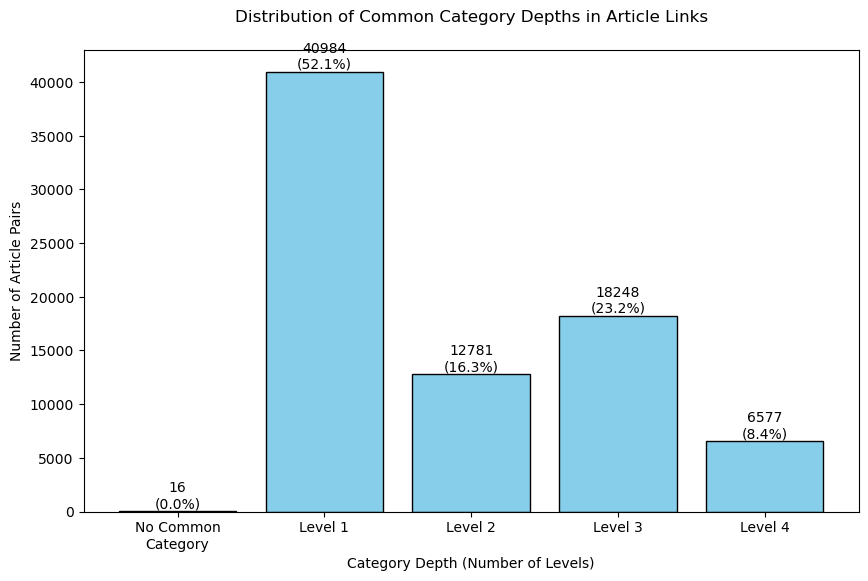

In [ ]:
df = pd.DataFrame(columns=['from', 'to'])
rows = []
for path in paths_unfinished['path']:
    nodes = path.split(';')
    for i in range(len(nodes) - 1):
        rows.append({'from': nodes[i], 'to': nodes[i + 1]})

df = pd.DataFrame(rows)

plot_category_depth_distribution(analyze_category_depths(df))

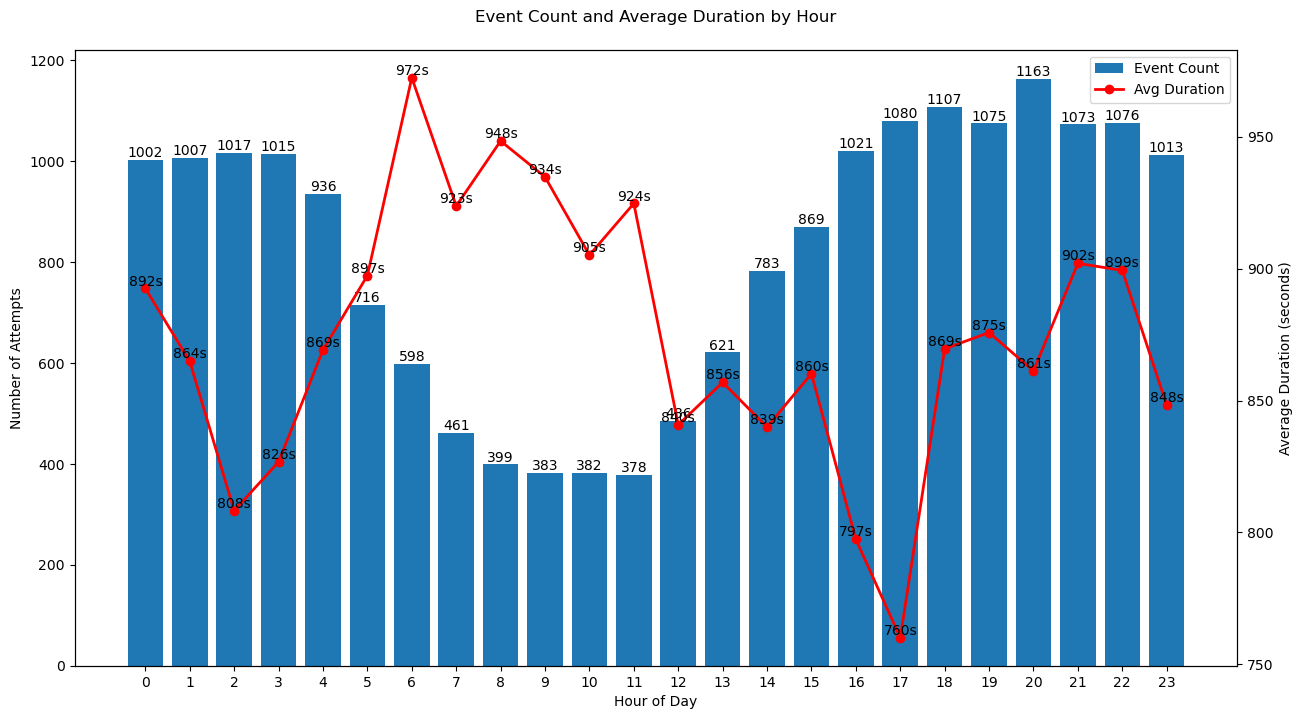

In [ ]:
analyze_time_info(paths_unfinished)

In [ ]:
paths_unfinished.shape

(19661, 8)

In [ ]:
# calculate the whole length of each path
paths_unfinished['path_length'] = paths_unfinished['path'].apply(lambda x: len([p for p in x.split(';')]))
path_unfinished_analysis = paths_unfinished[['path_length', 'durationInSec', 'type']].copy()
path_unfinished_analysis.head()

path_length  durationInSec     type
2            3           1818  timeout
4            2           1808  timeout
5            4           2009  timeout
6            7           1932  timeout
7            5            175  restart

In [ ]:
path_unfinished_analysis.describe()

path_length  durationInSec
count  19661.000000   19661.000000
mean       4.998067     864.843752
std        4.039215     883.902908
min        1.000000       7.000000
25%        3.000000     117.000000
50%        4.000000     291.000000
75%        6.000000    1858.000000
max      149.000000    9089.000000

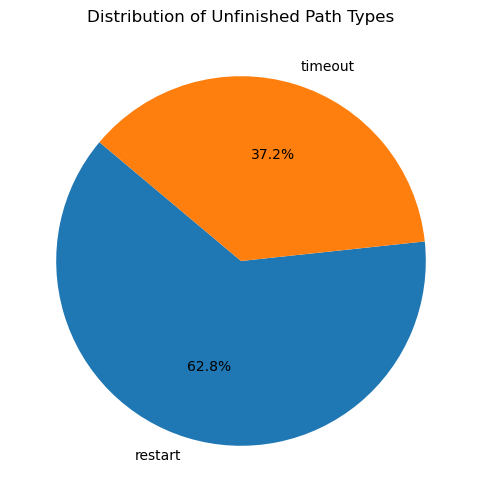

In [ ]:
type_counts = path_unfinished_analysis['type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Unfinished Path Types")
plt.show()

In [ ]:
with open('data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as file:
    data = file.readlines()
# remove comment 
data = [line.strip() for line in data if not line.startswith('#') and line.strip()]
# convert the data into a matrix
distance_matrix = [list(line) for line in data]
# convert the matrix into a DataFrame
df = pd.DataFrame(distance_matrix)
df.replace('_', pd.NA, inplace=True)
df = df.apply(pd.to_numeric)
df.head()

0     1     2     3     4     5     6     7     8     9     ...  4594  \
0   0.0   NaN   NaN   NaN   NaN   NaN   3.0   3.0   3.0   3.0  ...   4.0   
1   NaN   0.0   NaN   NaN   NaN   NaN   2.0   2.0   2.0   2.0  ...   4.0   
2   NaN   NaN   0.0   NaN   NaN   NaN   3.0   3.0   2.0   2.0  ...   4.0   
3   NaN   NaN   NaN   0.0   NaN   NaN   3.0   3.0   3.0   3.0  ...   4.0   
4   NaN   NaN   NaN   NaN   0.0   NaN   2.0   2.0   3.0   2.0  ...   4.0   

   4595  4596  4597  4598  4599  4600  4601  4602  4603  
0   3.0   3.0   4.0   4.0   3.0   4.0   4.0   4.0   2.0  
1   2.0   3.0   4.0   4.0   3.0   4.0   3.0   3.0   3.0  
2   3.0   2.0   3.0   4.0   3.0   4.0   3.0   3.0   3.0  
3   2.0   2.0   3.0   4.0   3.0   4.0   4.0   3.0   3.0  
4   2.0   3.0   4.0   4.0   3.0   4.0   3.0   3.0   3.0  

[5 rows x 4604 columns]

Mean shortest-path distance: 3.201729547596255
Median shortest-path distance: 3.0


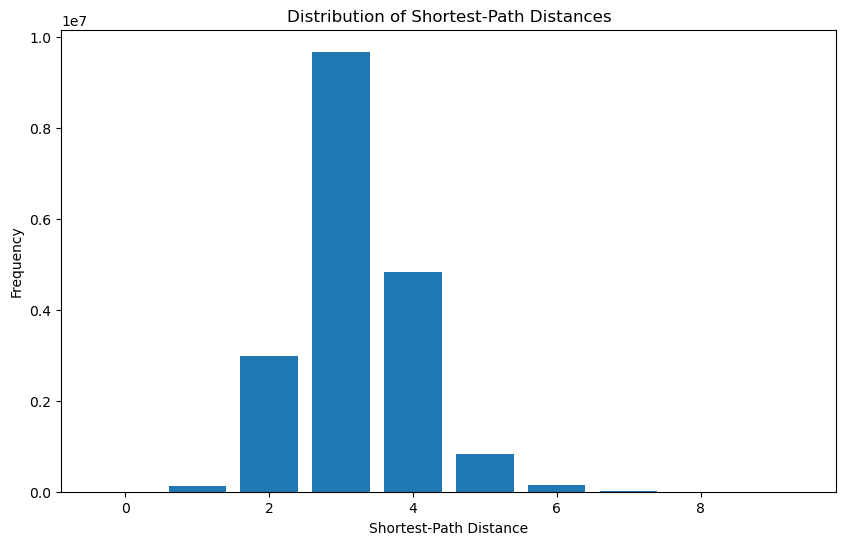

In [ ]:
distances = pd.Series(df.values.flatten())
distances = distances.dropna()

mean_distance = distances.mean()
median_distance = distances.median()

print(f"Mean shortest-path distance: {mean_distance}")
print(f"Median shortest-path distance: {median_distance}")

freq_dist = distances.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(freq_dist.index, freq_dist.values)
plt.title('Distribution of Shortest-Path Distances')
plt.xlabel('Shortest-Path Distance')
plt.ylabel('Frequency')
plt.show()

## OpenAI API

In [14]:
# Load links from the file
links_df = pd.read_csv('data\wikispeedia_paths-and-graph\links.tsv', sep='\t', names=["current_article", "linked_article"], comment='#')

In [ ]:
# Create a dictionary for faster lookup of links
link_map = {}
for idx, row in links_df.iterrows():
    link_map.setdefault(row['current_article'], []).append(row['linked_article'])


# Create OpenAI client
api_key = "Your OpenAI Key"
client = OpenAI(api_key = api_key)

In [17]:
start_article = "Aircraft"
target_article = "Google"

In [20]:
# Using GPT-3.5-Turbo
play_wikispeedia_game(start_article, target_article, link_map, client, model="gpt-3.5-turbo")

Step 0: Moved from 'Aircraft' to 'Boeing_747'
Step 1: Moved from 'Boeing_747' to 'Airbus'
Step 2: Moved from 'Airbus' to 'German_language'
Step 3: Moved from 'German_language' to 'Vienna'
Step 4: Moved from 'Vienna' to 'Wine'
Step 5: Moved from 'Wine' to 'Germany'
Step 6: Moved from 'Germany' to 'Google'
Reached the target article 'Google' in 7 steps!
Total token usage: 2436


In [21]:
# Using GPT-4o
play_wikispeedia_game(start_article, target_article, link_map, client, model="gpt-4o")

Step 0: Moved from 'Aircraft' to 'Boeing_747'
Step 1: Moved from 'Boeing_747' to 'United_States'
Step 2: Moved from 'United_States' to 'Internet'
Step 3: Moved from 'Internet' to 'World_Wide_Web'
Step 4: Moved from 'World_Wide_Web' to 'Google'
Reached the target article 'Google' in 5 steps!
Total token usage: 2306


In [23]:
# Using GPT-4o-mini
play_wikispeedia_game(start_article, target_article, link_map, client, model="gpt-4o-mini")

Step 0: Moved from 'Aircraft' to 'Boeing_747'
Step 1: Moved from 'Boeing_747' to 'United_States'
Step 2: Moved from 'United_States' to 'Internet'
Step 3: Moved from 'Internet' to 'World_Wide_Web'
Step 4: Moved from 'World_Wide_Web' to 'Gmail'
Step 5: Moved from 'Gmail' to 'Google'
Reached the target article 'Google' in 6 steps!
Total token usage: 2505


#### Cost of GPT-4.o-mini
Through our initial experiments, the estimated token usage for each path generation per step is around 400. The estimated average token usage for each 6-step path is around 2400. Using GPT-4.o-mini, the estimated cost of generating 10,000 6-step paths is under $5. Therefore it is affordable for us to do this project using this OpenAI model.